In [ ]:
# !unzip -q '/content/drive/MyDrive/flowers/flowers.zip' -d '/content/flowers'

In [1]:
import os
import torchvision.transforms as tt
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import statistics

In [2]:
image_size = 64
batch_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
print(os.getcwd())
DATA_DIR = 'jpg'

print(os.listdir(DATA_DIR))

train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([ tt.Resize(image_size),
                                                        tt.CenterCrop(image_size),
                                                        tt.ToTensor(),
                                                        tt.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

C:\Users\shiva\Desktop\projects
['flowers']


'cuda'

# GENERATOR - DISCRIMINATOR

In [3]:
latent_size = 256

In [4]:
class Generator(nn.Module):
    def __init__(self, latent_size):
        super(Generator, self).__init__()

        # self.embeddings = text_embeddings(input)

        self.main = nn.Sequential(
            # latent_size x 1 x 1
            nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # 512 x 4 x 4
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # 256 x 8 x 8
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # 128 x 16 x 16
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # 64 x 32 x 32
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh(),
            # 3 x 64 x 64
            # nn.ConvTranspose2d(3, 3, kernel_size=4, stride=2, padding=1, bias=False),
            # nn.Tanh()
            # # 3 x 128 x 128
        )

    def forward(self, x):
        return self.main(x)

generator = Generator(latent_size).to(device)

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            # # 3 x 128 x 128

            # nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=False),
            # nn.BatchNorm2d(32),
            # nn.LeakyReLU(0.2, inplace=True),

            # 3 x 64 x 64
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # 64 x 32 x 32
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # 128 x 16 x 16
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # 256 x 8 x 8
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # 512 x 4 x 4
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            # 1 x 1 x 1
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

discriminator = Discriminator().to(device)

In [6]:
latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
fake_images = generator(latent)
fake_labels = discriminator(fake_images)
print(fake_images.size(), fake_labels.size())

torch.Size([64, 3, 64, 64]) torch.Size([64, 1])


#TRAINING

In [7]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_images = real_images.to(device)
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [8]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [9]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        loss_d_lst = []
        loss_g_lst = []
        real_score_lst = []
        fake_score_lst = []
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            loss_d_lst.append(loss_d)
            real_score_lst.append(real_score)
            fake_score_lst.append(fake_score)
            # Train generator
            loss_g = train_generator(opt_g)
            loss_g_lst.append(loss_g)
            
        # Record losses & scores
        loss_g = statistics.mean(loss_g_lst)
        loss_d = statistics.mean(loss_d_lst)
        real_score = statistics.mean(real_score_lst)
        fake_score = statistics.mean(fake_score_lst)

        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # # Save generated images
        # save_samples(epoch+start_idx, fixed_latent, show=False)

        #Show Samples
        # latent = torch.randn(1, latent_size, 1, 1, device=device)
        # fake_images = generator(latent)
        # print(fake_images.size())
        # fake_images = torch.squeeze(fake_images)
        # print(fake_images.size())
        # plt.imshow(fake_images.permute(1, 2, 0).cpu().detach().numpy())
        # plt.show()
    
    return losses_g, losses_d, real_scores, fake_scores

In [10]:
epochs = 100
lr = 0.0002

history = fit(epochs, lr)

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [1/100], loss_g: 7.9157, loss_d: 0.4416, real_score: 0.8517, fake_score: 0.1494


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 5.7379, loss_d: 0.4401, real_score: 0.8839, fake_score: 0.0933


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 4.6236, loss_d: 0.3305, real_score: 0.8842, fake_score: 0.1151


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 2.9318, loss_d: 0.7164, real_score: 0.7562, fake_score: 0.2354


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 3.2930, loss_d: 0.7815, real_score: 0.7417, fake_score: 0.2581


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 3.2220, loss_d: 0.7092, real_score: 0.7597, fake_score: 0.2380


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 3.5703, loss_d: 0.5920, real_score: 0.7930, fake_score: 0.2031


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 3.6842, loss_d: 0.5591, real_score: 0.7978, fake_score: 0.1970


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 3.6459, loss_d: 0.6404, real_score: 0.7823, fake_score: 0.2166


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 3.4955, loss_d: 0.6164, real_score: 0.7808, fake_score: 0.2160


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 3.3354, loss_d: 0.6699, real_score: 0.7648, fake_score: 0.2310


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 3.3520, loss_d: 0.6788, real_score: 0.7680, fake_score: 0.2306


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 3.2704, loss_d: 0.6403, real_score: 0.7748, fake_score: 0.2188


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 3.3358, loss_d: 0.5832, real_score: 0.7910, fake_score: 0.2064


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 3.3662, loss_d: 0.5985, real_score: 0.7914, fake_score: 0.2066


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 3.4396, loss_d: 0.5606, real_score: 0.7999, fake_score: 0.1970


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 3.4876, loss_d: 0.5798, real_score: 0.7992, fake_score: 0.1991


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 3.3982, loss_d: 0.5528, real_score: 0.8076, fake_score: 0.1877


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 3.3446, loss_d: 0.5345, real_score: 0.8075, fake_score: 0.1906


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 3.4399, loss_d: 0.5986, real_score: 0.7973, fake_score: 0.2004


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 3.2601, loss_d: 0.5945, real_score: 0.7957, fake_score: 0.2004


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 3.2472, loss_d: 0.6197, real_score: 0.7918, fake_score: 0.2084


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 3.2120, loss_d: 0.5676, real_score: 0.8042, fake_score: 0.1931


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [24/100], loss_g: 3.2879, loss_d: 0.6226, real_score: 0.7981, fake_score: 0.1991


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [25/100], loss_g: 3.1382, loss_d: 0.4883, real_score: 0.8192, fake_score: 0.1783


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [26/100], loss_g: 3.0922, loss_d: 0.6484, real_score: 0.7896, fake_score: 0.2130


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [27/100], loss_g: 3.2817, loss_d: 0.6403, real_score: 0.7951, fake_score: 0.2035


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [28/100], loss_g: 3.1645, loss_d: 0.5701, real_score: 0.8100, fake_score: 0.1861


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [29/100], loss_g: 3.2137, loss_d: 0.4984, real_score: 0.8220, fake_score: 0.1760


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [30/100], loss_g: 3.2717, loss_d: 0.5042, real_score: 0.8298, fake_score: 0.1710


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [31/100], loss_g: 3.2101, loss_d: 0.5023, real_score: 0.8216, fake_score: 0.1766


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [32/100], loss_g: 3.4146, loss_d: 0.4465, real_score: 0.8402, fake_score: 0.1581


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [33/100], loss_g: 3.2220, loss_d: 0.5686, real_score: 0.8178, fake_score: 0.1799


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [34/100], loss_g: 3.3009, loss_d: 0.4409, real_score: 0.8398, fake_score: 0.1604


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [35/100], loss_g: 3.1720, loss_d: 0.4702, real_score: 0.8359, fake_score: 0.1613


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [36/100], loss_g: 3.4458, loss_d: 0.4230, real_score: 0.8450, fake_score: 0.1537


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [37/100], loss_g: 3.4722, loss_d: 0.4561, real_score: 0.8369, fake_score: 0.1600


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [38/100], loss_g: 3.3079, loss_d: 0.5081, real_score: 0.8293, fake_score: 0.1686


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [39/100], loss_g: 3.3520, loss_d: 0.5071, real_score: 0.8395, fake_score: 0.1608


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [40/100], loss_g: 3.3616, loss_d: 0.3064, real_score: 0.8762, fake_score: 0.1225


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [41/100], loss_g: 3.5059, loss_d: 0.4364, real_score: 0.8500, fake_score: 0.1482


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [42/100], loss_g: 3.3850, loss_d: 0.5561, real_score: 0.8295, fake_score: 0.1687


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [43/100], loss_g: 3.3200, loss_d: 0.4457, real_score: 0.8556, fake_score: 0.1440


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [44/100], loss_g: 3.5142, loss_d: 0.3535, real_score: 0.8748, fake_score: 0.1250


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [45/100], loss_g: 3.7140, loss_d: 0.3484, real_score: 0.8730, fake_score: 0.1254


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [46/100], loss_g: 3.6597, loss_d: 0.4256, real_score: 0.8586, fake_score: 0.1419


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [47/100], loss_g: 3.6640, loss_d: 0.3228, real_score: 0.8775, fake_score: 0.1204


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [48/100], loss_g: 3.9238, loss_d: 0.3862, real_score: 0.8688, fake_score: 0.1318


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [49/100], loss_g: 3.6585, loss_d: 0.2625, real_score: 0.8940, fake_score: 0.1021


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [50/100], loss_g: 3.7080, loss_d: 0.4382, real_score: 0.8703, fake_score: 0.1294


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [51/100], loss_g: 3.6937, loss_d: 0.2984, real_score: 0.8935, fake_score: 0.1050


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [52/100], loss_g: 4.0786, loss_d: 0.3566, real_score: 0.8830, fake_score: 0.1190


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [53/100], loss_g: 3.7358, loss_d: 0.2725, real_score: 0.8929, fake_score: 0.1035


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [54/100], loss_g: 3.9039, loss_d: 0.4267, real_score: 0.8875, fake_score: 0.1117


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [55/100], loss_g: 3.7089, loss_d: 0.2427, real_score: 0.9032, fake_score: 0.0981


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [56/100], loss_g: 3.9550, loss_d: 0.4357, real_score: 0.8758, fake_score: 0.1226


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [57/100], loss_g: 3.8248, loss_d: 0.2792, real_score: 0.8921, fake_score: 0.1058


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [58/100], loss_g: 4.0544, loss_d: 0.2336, real_score: 0.9089, fake_score: 0.0890


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [59/100], loss_g: 4.2197, loss_d: 0.2406, real_score: 0.9275, fake_score: 0.0761


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [60/100], loss_g: 3.7273, loss_d: 0.4855, real_score: 0.8488, fake_score: 0.1477


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [61/100], loss_g: 3.9383, loss_d: 0.1557, real_score: 0.9321, fake_score: 0.0675


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [62/100], loss_g: 3.7437, loss_d: 0.6346, real_score: 0.8608, fake_score: 0.1371


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [63/100], loss_g: 3.5768, loss_d: 0.3119, real_score: 0.8808, fake_score: 0.1188


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [64/100], loss_g: 4.0706, loss_d: 0.2640, real_score: 0.9146, fake_score: 0.0861


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [65/100], loss_g: 3.9865, loss_d: 0.2286, real_score: 0.9115, fake_score: 0.0876


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [66/100], loss_g: 4.2222, loss_d: 0.2695, real_score: 0.9240, fake_score: 0.0745


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [67/100], loss_g: 3.9981, loss_d: 0.2426, real_score: 0.9049, fake_score: 0.0950


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [68/100], loss_g: 4.2565, loss_d: 0.3405, real_score: 0.9054, fake_score: 0.0956


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [69/100], loss_g: 3.9780, loss_d: 0.2146, real_score: 0.9147, fake_score: 0.0832


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [70/100], loss_g: 4.3690, loss_d: 0.1101, real_score: 0.9517, fake_score: 0.0484


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [71/100], loss_g: 4.0573, loss_d: 0.5113, real_score: 0.8619, fake_score: 0.1372


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [72/100], loss_g: 4.1614, loss_d: 0.1187, real_score: 0.9470, fake_score: 0.0534


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [73/100], loss_g: 4.0012, loss_d: 0.4413, real_score: 0.8765, fake_score: 0.1221


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [74/100], loss_g: 4.3385, loss_d: 0.1102, real_score: 0.9513, fake_score: 0.0488


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [75/100], loss_g: 4.2980, loss_d: 0.4200, real_score: 0.8795, fake_score: 0.1203


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [76/100], loss_g: 4.2700, loss_d: 0.1168, real_score: 0.9478, fake_score: 0.0510


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [77/100], loss_g: 4.6411, loss_d: 0.1006, real_score: 0.9561, fake_score: 0.0433


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [78/100], loss_g: 4.7284, loss_d: 0.0772, real_score: 0.9647, fake_score: 0.0350


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [79/100], loss_g: 4.5693, loss_d: 0.6446, real_score: 0.8956, fake_score: 0.1030


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [80/100], loss_g: 3.9138, loss_d: 0.3609, real_score: 0.8768, fake_score: 0.1258


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [81/100], loss_g: 4.3057, loss_d: 0.1389, real_score: 0.9405, fake_score: 0.0586


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [82/100], loss_g: 4.6102, loss_d: 0.0728, real_score: 0.9662, fake_score: 0.0339


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [83/100], loss_g: 4.6662, loss_d: 0.4264, real_score: 0.9218, fake_score: 0.0769


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [84/100], loss_g: 3.7800, loss_d: 0.4327, real_score: 0.8561, fake_score: 0.1442


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [85/100], loss_g: 4.3766, loss_d: 0.1250, real_score: 0.9458, fake_score: 0.0534


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [86/100], loss_g: 4.5488, loss_d: 0.2517, real_score: 0.9494, fake_score: 0.0551


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [87/100], loss_g: 4.0132, loss_d: 0.3595, real_score: 0.8810, fake_score: 0.1137


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [88/100], loss_g: 4.5157, loss_d: 0.1913, real_score: 0.9273, fake_score: 0.0730


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [89/100], loss_g: 4.6476, loss_d: 0.0685, real_score: 0.9680, fake_score: 0.0318


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [90/100], loss_g: 4.9367, loss_d: 0.0546, real_score: 0.9742, fake_score: 0.0258


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [91/100], loss_g: 5.0771, loss_d: 0.3469, real_score: 0.9424, fake_score: 0.0559


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [92/100], loss_g: 4.1224, loss_d: 0.2711, real_score: 0.9025, fake_score: 0.0991


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [93/100], loss_g: 4.4779, loss_d: 0.5724, real_score: 0.9278, fake_score: 0.0750


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [94/100], loss_g: 4.5216, loss_d: 0.1462, real_score: 0.9399, fake_score: 0.0601


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [95/100], loss_g: 4.8397, loss_d: 0.0685, real_score: 0.9680, fake_score: 0.0310


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [96/100], loss_g: 5.0038, loss_d: 0.0535, real_score: 0.9745, fake_score: 0.0246


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [97/100], loss_g: 5.2042, loss_d: 0.0520, real_score: 0.9760, fake_score: 0.0243


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [98/100], loss_g: 4.5232, loss_d: 0.6163, real_score: 0.8932, fake_score: 0.1076


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [99/100], loss_g: 4.6616, loss_d: 0.1194, real_score: 0.9487, fake_score: 0.0505


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [100/100], loss_g: 5.0067, loss_d: 0.0705, real_score: 0.9677, fake_score: 0.0314


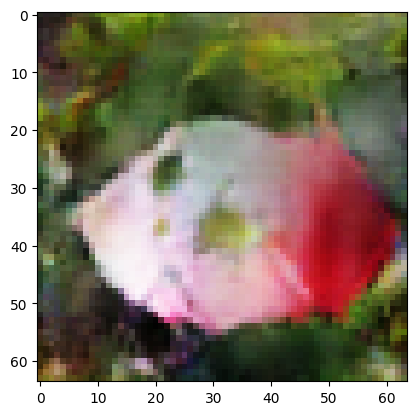

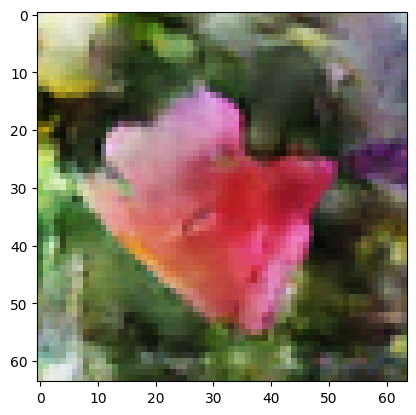

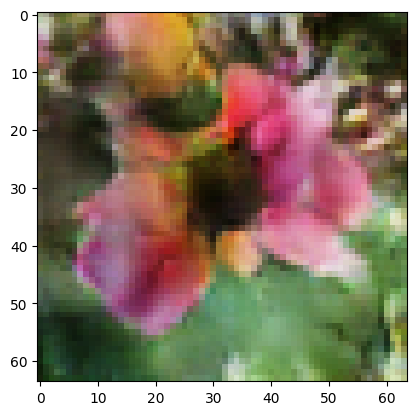

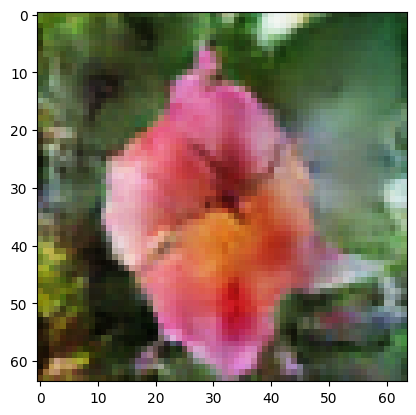

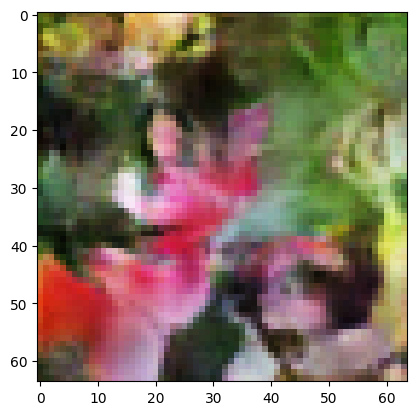

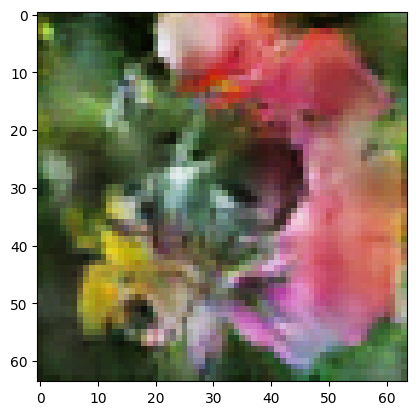

In [11]:
for i in range(6):
    latent = torch.randn(1, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    fake_images = torch.squeeze(fake_images)
    fake_images = (fake_images + 1) / 2
    plt.imshow(fake_images.permute(2, 1, 0).cpu().detach().numpy())
    plt.show()